In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sign(x):
    return (x >= 0).astype(int)*2 - 1

In [49]:
d = 2
w = np.random.randn(d)
# X = np.column_stack([
#     np.linspace(-10., 10., 201),
#     np.ones((201, d-1))
# ])
X = np.random.rand(2000, d) * 10. - 5. 
X.shape, w

((2000, 2), array([ 1.08437234, -0.56539918]))

In [50]:
Y = sign(X @ w)
Y.shape

(2000,)

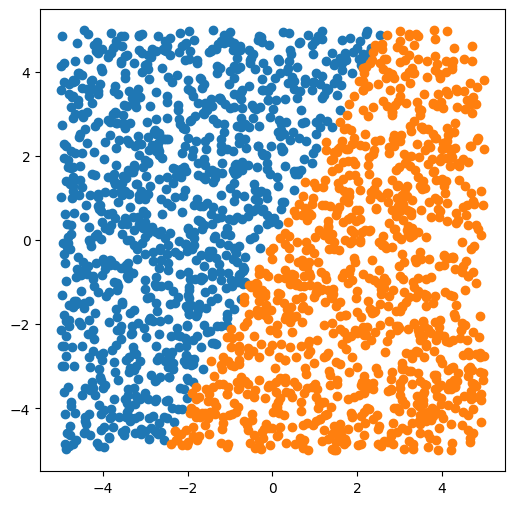

In [51]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], label='-1')
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], label='+1')
plt.show()

In [52]:
from sklearn.linear_model import LogisticRegression
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling

estimator = LogisticRegression(penalty=None, fit_intercept=False)
learner = ActiveLearner(
    estimator=estimator,
    query_strategy=uncertainty_sampling, 
    X_training=np.array([X[0], -X[0]]),
    y_training=np.array([Y[0], -Y[0]])
)

In [53]:
perf_hist = [learner.score(X, Y)]
coefs = [learner.estimator.coef_.copy()]
n_queries = 25
X_pool = X.copy()[1:]
Y_pool = Y.copy()[1:]
X_seen = X.copy()[0].reshape(1, -1)
Y_seen = Y.copy()[0].reshape(-1,)
queries = []
metrics = []

for i in range(n_queries):
    query_idx, query_instance, query_metrics = learner.query(X_pool, return_metrics=True)
    queries.append(query_instance)
    metrics.append(query_metrics)
    X_seen = np.concatenate([X_seen, X_pool[query_idx].reshape(1, -1)], axis=0)
    Y_seen = np.concatenate([Y_seen, Y_pool[query_idx].reshape(-1,)])

    learner.teach(X_pool[query_idx].reshape(1, -1), Y_pool[query_idx.reshape(-1,)])
    perf_hist.append(learner.score(X, Y))
    coefs.append(learner.estimator.coef_.copy())

    X_pool = np.delete(X_pool, query_idx, axis=0)
    Y_pool = np.delete(Y_pool, query_idx)

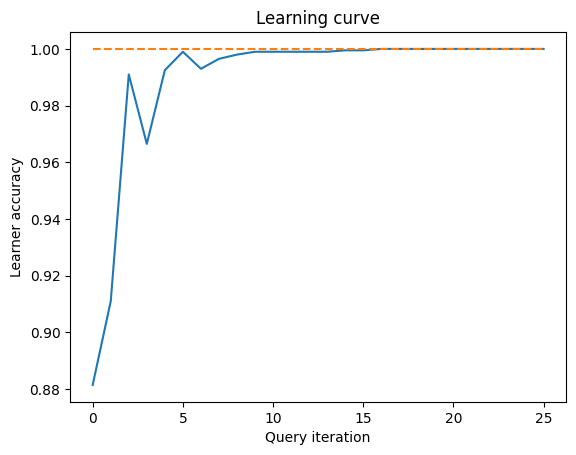

In [54]:
plt.plot(range(n_queries+1), perf_hist)
plt.plot(range(n_queries+1), np.ones(len(perf_hist)), linestyle='dashed')
plt.xlabel('Query iteration')
plt.ylabel('Learner accuracy')
plt.title('Learning curve')
plt.show()

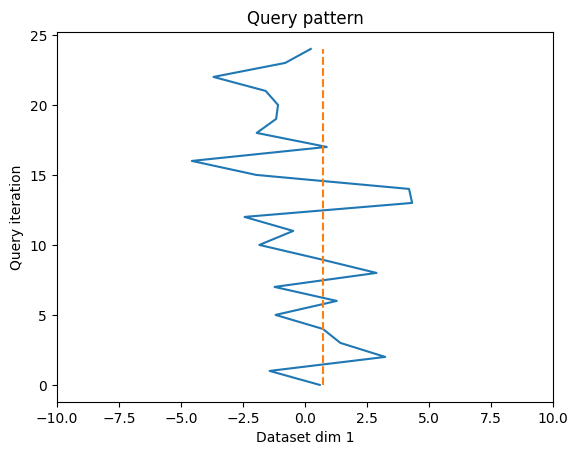

In [46]:
plt.plot(np.array(queries)[:, 0, 0], range(n_queries))
plt.plot(-w[1] / w[0] * np.ones(n_queries), range(n_queries), linestyle='dashed')
plt.xlim(-10, 10)
plt.xlabel('Dataset dim 1')
plt.ylabel('Query iteration')
plt.title('Query pattern')
plt.show()

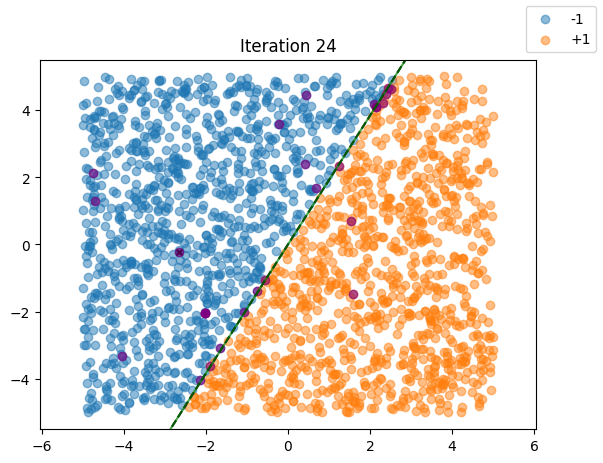

In [60]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# coefs = [-w[0] / w[1]]*n_queries
true_coef = -w[0] / w[1]

fig, ax = plt.subplots()
ax.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], label='-1', alpha=0.5)
ax.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], label='+1', alpha=0.5)
fig.legend()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([xlim[0], xlim[1]], [true_coef*xlim[0], true_coef*xlim[1]], c='black', linestyle='dashed')
ax.set_ylim(ylim)
title = ax.set_title('')

ln, = ax.plot([], [], c='green', alpha=0.7)
sc = ax.scatter([], [], c='black', marker='x', s=20)

def animate(i):
    curr_coef = -coefs[i][0, 0] / coefs[i][0, 1] 
    ln.set_data([xlim[0], xlim[1]], [curr_coef*xlim[0], curr_coef*xlim[1]])
    sc.set_offsets((queries[i][0, 0], queries[i][0, 1]))
    ax.scatter(queries[i][0, 0], queries[i][0, 1], c='purple', alpha=0.6)
    title.set_text(f'Iteration {i}')

    return ln, sc, title

ani = FuncAnimation(fig, animate, frames=n_queries, interval=500, blit=True, repeat=False)
HTML(ani.to_html5_video())

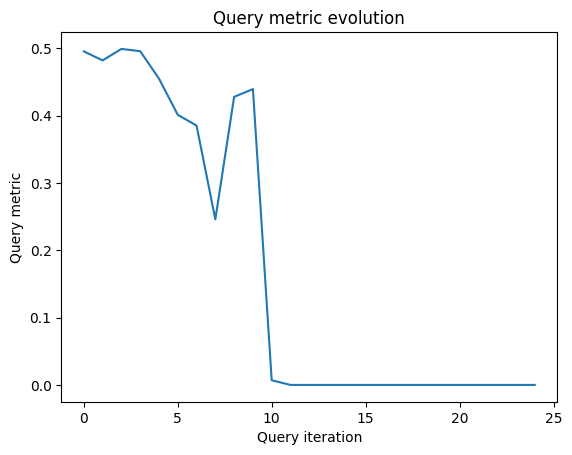

In [47]:
plt.plot(range(n_queries), metrics)
plt.xlabel('Query iteration')
plt.ylabel('Query metric')
plt.title('Query metric evolution')
plt.show()